In [1]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [2]:
from torchvision import datasets, transforms


data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [3]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

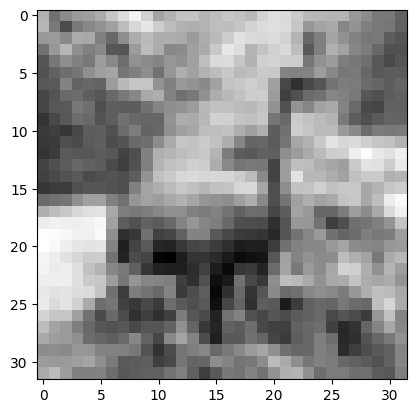

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img.mean(0), cmap='gray')
plt.show()

# Padding Boundary

In [9]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [10]:
import torch

with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

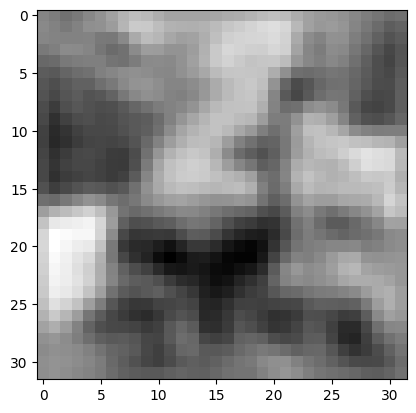

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

# Pooling

In [13]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

# Combination with Full Model

In [14]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2)
)

In [15]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ... <1>
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [16]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

# Network with Subclassing

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

# Functional API

In [4]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # without instantiate in init method
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # without instantiate in init method
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0411, -0.0358]], grad_fn=<AddmmBackward0>)

# Training ConvNet

In [21]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [28]:
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-01-19 04:27:55.454767 Epoch 1, Training loss 0.5804177875731401
2023-01-19 04:28:21.412502 Epoch 10, Training loss 0.322604932223156
2023-01-19 04:28:49.941205 Epoch 20, Training loss 0.290214629879423
2023-01-19 04:29:19.658806 Epoch 30, Training loss 0.2664595464612268
2023-01-19 04:29:49.138860 Epoch 40, Training loss 0.24809699235068763
2023-01-19 04:30:22.040087 Epoch 50, Training loss 0.23048108080579977
2023-01-19 04:30:54.535498 Epoch 60, Training loss 0.21473691987383897
2023-01-19 04:31:23.566669 Epoch 70, Training loss 0.20075724254937688
2023-01-19 04:31:52.686164 Epoch 80, Training loss 0.1832931741692458
2023-01-19 04:32:21.003606 Epoch 90, Training loss 0.16998054533247736
2023-01-19 04:32:49.606134 Epoch 100, Training loss 0.15532025080292847


In [30]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [31]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad(): # not update parameter
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # give index highest value output
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            
            print("Accuracy {}: {:.2f}".format(name , correct / total))

In [32]:
validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


# Saving and load Model

In [33]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [34]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

# Moving Computation to GPU

In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [24]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

# Adding Memory Capacity with Width

In [26]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Generalize Model

The first way to stabilize generalization is to add a regularization term to the loss. This
term is crafted so that the weights of the model tend to be small on their own, limiting
how much training makes them grow. In other words, it is a penalty on larger weight
values. This makes the loss have a smoother topography, and there’s relatively less to
gain from fitting individual samples.

The most popular regularization terms of this kind are L2 regularization, which is
the sum of squares of all weights in the model, and L1 regularization, which is the sum
of the absolute values of all weights in the model. Both of them are scaled by a
(small) factor, which is a hyperparameter we set prior to training.

L2 regularization is also referred to as weight decay. The reason for this name is that,
thinking about SGD and backpropagation, the negative gradient of the L2 regularization term with respect to a parameter `w_i` is - `2 * lambda * w_i`, where lambda is the aforementioned hyperparameter, simply named weight decay in PyTorch. So, adding L2 regularization to the loss function is equivalent to decreasing each weight by an amount proportional to its current value during the optimization step (hence, the
name weight decay). Note that weight decay applies to all parameters of the network, such as biases.

In PyTorch, we could implement regularization pretty easily by adding a term to the loss. After computing the loss, whatever the loss function is, we can iterate the parameters of the model, sum their respective square (for L2) or abs (for L1), and backpropagate:

In [27]:
def training_loop_l2_reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # Replaces pow(2.0) with abs() for L1 regularization
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

However, the SGD optimizer in PyTorch already has a `weight_decay` parameter that corresponds to `2 * lambda`, and it directly performs weight decay during the update as described previously. It is fully equivalent to adding the L2 norm of weights to the loss, without the need for accumulating terms in the loss and involving autograd.

# Dropout

An effective strategy for combating overfitting was originally proposed in 2014 by Nitish Srivastava and coauthors from Geoff Hinton’s group in Toronto, in a paper aptly entitled “Dropout: a Simple Way to Prevent Neural Networks from Overfitting” (http://mng.bz/nPMa). The idea behind dropout is indeed simple: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration.

This procedure effectively generates slightly different models with different neuron topologies at each iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting. An alternative point of view is that dropout perturbs the features being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network.

In PyTorch, we can implement dropout in a model by adding an `nn.Dropout` module between the nonlinear activation function and the linear or convolutional module of the subsequent layer. As an argument, we need to specify the probability with which inputs will be zeroed out. In case of convolutions, we’ll use the specialized `nn.Dropout2d` or `nn.Dropout3d`, which zero out entire channels of the input:

In [28]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Batch Normalization

Dropout was all the rage when, in 2015, another seminal paper was published by Sergey Ioffe and Christian Szegedy from Google, entitled “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” (https://arxiv.org/abs/1502.03167). The paper described a technique that had multiple beneficial effects on training: allowing us to increase the learning rate and make training less dependent on initialization and act as a regularizer, thus representing an alternative to dropout.

The main idea behind batch normalization is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution. Recalling the mechanics of learning and the role of nonlinear activation functions, this helps avoid the inputs to activation functions being too far into the saturated portion of the function, thereby killing gradients and slowing training.

In practical terms, batch normalization shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch. The regularization effect is a result of the fact that an individual sample and its downstream activations are always seen by the model as shifted and scaled, depending on the statistics across the randomly extracted minibatch. This is in itself a form of principled augmentation. The authors of the paper suggest that using batch normalization eliminates or at least alleviates the need for dropout.

Batch normalization in PyTorch is provided through the `nn.BatchNorm1D`, `nn.BatchNorm2d`, and `nn.BatchNorm3d` modules, depending on the dimensionality of the input. Since the aim for batch normalization is to rescale the inputs of the activations, the natural location is after the linear transformation (convolution, in this case) and the activation, as shown here:

In [23]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Skip Connection

Original NetDepth without skip connection

In [5]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

Adding skip connection

In [6]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)

        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Building Very Deep Network

Exceeding 100 layers in a convolutional neural network, The standard strategy is to define a building block, such as a (Conv2d, ReLU, Conv2d) + skip connection block, and then build the network dynamically in a for loop. Let’s see it done in practice.

We first create a module subclass whose sole job is to provide the computation for one
block—that is, one group of convolutions, activation, and skip connection:

In [7]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

Since we’re planning to generate a deep model, we are including batch normalization in the block, since this will help prevent gradients from vanishing during training. We’d now like to generate a 100-block network.